# Creating a 3-D plot of the planetary boundary layer heights over the Roosevelt road in Chicago using the HRRR.
## Overview
### Within this notebook, we will cover:
#### 1. How to plot a 3-D view of the PBL over a small areas

# Imports

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from herbie import Herbie
from PIL import Image
from IPython.display import display, Image as IPImage
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Creating a function to download all required grib files from Herbie. 
A second function is used to create interpolation points along the coordinate line for finer resolution data

In [24]:
def download_files(date, model, max_fxx):
    forecast_range = range(0, max_fxx + 1)
    file_paths = {'pbl': []}
    
    for fxx in forecast_range:
        H = Herbie(date, model=model, product="nat", source='aws', fxx=fxx)
        file_path = H.download(":HPBL:surface")
        if file_path.exists():
            file_paths['pbl'].append(file_path)
            print(f"Downloaded and saved file for forecast hour {fxx}: {file_path}")
        else:
            print(f"Failed to download file for forecast hour {fxx}")

    return file_paths

def interpolate_coords(start, end, num_points):
    """Interpolate coordinates between start and end."""
    return [(start[0] + i * (end[0] - start[0]) / num_points,
             start[1] + i * (end[1] - start[1]) / num_points) for i in range(num_points + 1)]

# Function to create the plot and data, as well as using the haversine function to find the distance between the start and end point

In [27]:
def create_frame_time_height(file_paths, output_dir, init_time, model_name):
    fig = plt.figure(figsize=[12, 8], dpi=300)
    ax = fig.add_subplot(111, projection='3d')

    print(f"Creating time-height frame for PBL height along Roosevelt Road in Chicago")

    try:
        # Define coordinates along Roosevelt Road from the Shedd Aquarium to Cicero Avenue
        roosevelt_coords = [
            (-87.613881, 41.867572),  # Shedd Aquarium
            (-87.665318, 41.866745),  # Intermediate point
            (-87.708893, 41.865102)   # Cicero Avenue
        ]

        # Interpolate 50 points between the three main coordinates to reduce memory usage
        num_interpolated_points = 50
        interpolated_coords = []
        for i in range(len(roosevelt_coords) - 1):
            interpolated_coords.extend(interpolate_coords(roosevelt_coords[i], roosevelt_coords[i + 1], num_interpolated_points // (len(roosevelt_coords) - 1)))

        pbl_heights = []
        times = []
        lons = []
        lats = []

        for fxx, file_pbl in enumerate(file_paths['pbl']):
            if not os.path.exists(file_pbl):
                print(f"File does not exist: {file_pbl}")
                continue

            ds_pbl = xr.open_dataset(file_pbl, engine='cfgrib', filter_by_keys={'typeOfLevel': 'surface'})

            # Find the nearest point using the haversine formula
            lon = ds_pbl.longitude.values
            lat = ds_pbl.latitude.values

            def haversine(lon1, lat1, lon2, lat2):
                R = 6371  # Earth radius in kilometers
                lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
                dlon = lon2 - lon1
                dlat = lat2 - lat1
                a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
                c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
                return R * c

            for lon_spot, lat_spot in interpolated_coords:
                distances = haversine(lon, lat, lon_spot, lat_spot)
                min_dist_index = np.unravel_index(np.argmin(distances), distances.shape)
                pbl_height = ds_pbl['blh'].isel(x=min_dist_index[1], y=min_dist_index[0]).values

                pbl_heights.append(pbl_height)
                times.append(init_time + np.timedelta64(fxx, 'h'))
                lons.append(lon_spot)
                lats.append(lat_spot)

        if not pbl_heights or not times or not lons or not lats:
            print("No data available to plot.")
            return None

        # Convert lists to numpy arrays
        pbl_heights = np.array(pbl_heights, dtype=np.float64)
        times = np.array(times, dtype='datetime64[h]')
        lons = np.array(lons, dtype=np.float64)
        lats = np.array(lats, dtype=np.float64)

        # Create grid for the surface plot
        times_unique = np.unique(times)
        lons_unique = np.unique(lons)
        times_grid, lons_grid = np.meshgrid(times_unique.astype('float64'), lons_unique)
        pbl_grid = np.zeros_like(times_grid, dtype=np.float64)

        for i, time in enumerate(times_unique):
            for j, lon in enumerate(lons_unique):
                mask = (times == time) & (lons == lon)
                if np.any(mask):
                    pbl_grid[j, i] = pbl_heights[mask][0]

        # Create the 3D surface plot with solid color
        surf = ax.plot_surface(times_grid, lons_grid, pbl_grid, cmap='viridis', edgecolor='none')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='PBL Height (m)')
        
        # Add custom longitude labels for the original 3 points
        original_coords = roosevelt_coords
        original_lon_labels = ['Shedd Aquarium', 'Intermediate', 'Cicero Avenue']
        original_lon_values = [lon for lon, lat in original_coords]
        
        ax.set_yticks(original_lon_values)
        ax.set_yticklabels(original_lon_labels, rotation=0, ha='right')
        
        # Format the time axis to show forecast hours every 6 hours
        forecast_hours = np.array([(t - times_unique[0]) / np.timedelta64(1, 'h') for t in times_unique])
        six_hour_indices = np.arange(0, len(forecast_hours), 6)
        ax.set_xticks(times_unique[six_hour_indices].astype('float64'))
        ax.set_xticklabels([f'F{int(fh)}' for fh in forecast_hours[six_hour_indices]])
        
        ax.set_xlabel('Forecast Hour')
        ax.set_zlabel('PBL Height (m)', labelpad=20)  # Increase labelpad for better spacing
        ax.set_title(f'3D Time-Height Plot of PBL Height along Roosevelt Road in Chicago\nModel Initialization: {init_time}')
        
        # Adjust the view angle to look from the time axis
        ax.view_init(elev=20, azim=60)  # Adjusted angles for better visibility from the time axis
        
        # Adjust layout to prevent overlapping
        plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)
        
        # Adjust the z-axis tick parameters for better spacing
        ax.zaxis.set_tick_params(pad=10)
        
        frame_filename = os.path.join(output_dir, "time_height_plot_3d.png")
        plt.savefig(frame_filename, bbox_inches='tight')
        plt.close(fig)

        return frame_filename
    except Exception as e:
        print(f"Error creating time-height frame: {e}")
        return None

def create_animated_gif_time_height(date, model, max_fxx, output_gif):
    output_dir = "frames_time_height"
    os.makedirs(output_dir, exist_ok=True)

    init_time = np.datetime64(date)
    model_name = model.upper()

    file_paths = download_files(date, model, max_fxx)

    frame_filename = create_frame_time_height(file_paths, output_dir, init_time, model_name)

    if frame_filename and os.path.exists(frame_filename):
        with Image.open(frame_filename) as img:
            img.save(output_gif, format='GIF', save_all=True, duration=500, loop=0)
    else:
        print("Failed to create frame, skipping GIF creation.")

    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

    for key in file_paths:
        for file_path in file_paths[key]:
            if os.path.exists(file_path):
                os.remove(file_path)
            original_file_path = str(file_path).replace(f"subset_{key}_", "")
            if os.path.exists(original_file_path):
                os.remove(original_file_path)

    date_dir = os.path.join("C:\\Users\\thewe\\data\\hrrr", date.split()[0].replace("-", ""))
    if os.path.exists(date_dir):
        for root, dirs, files in os.walk(date_dir, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
        os.rmdir(date_dir)

    if not os.listdir(output_dir):
        os.rmdir(output_dir)

# Inputting your day and forecast time as well as using the function

Enter the date (e.g., 2024-06-24 18:00):  2024-07-21 00:00
Enter the maximum forecast hour (For 0, 6, 12, 18z, its 48, anything else it's 18):  48


✅ Found ┊ model=hrrr ┊ product=nat ┊ 2024-Jul-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\thewe\data\hrrr\20240721]
Downloaded and saved file for forecast hour 0: C:\Users\thewe\data\hrrr\20240721\subset_14ef4ecf__hrrr.t00z.wrfnatf00.grib2
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2024-Jul-21 00:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws
Downloaded and saved file for forecast hour 1: C:\Users\thewe\data\hrrr\20240721\subset_14e44ecf__hrrr.t00z.wrfnatf01.grib2
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2024-Jul-21 00:00 UTC F02 ┊ GRIB2 @ aws ┊ IDX @ aws
Downloaded and saved file for forecast hour 2: C:\Users\thewe\data\hrrr\20240721\subset_142179e5__hrrr.t00z.wrfnatf02.grib2
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2024-Jul-21 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
Downloaded and saved file for forecast hour 3: C:\Users\thewe\data\hrrr\20240721\subset_141579e5__hrrr.t00z.wrfnatf03.grib2
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2024-Jul-21 00:00 UTC F04 ┊ GRIB2 @ aws ┊ IDX @ aws

Cannot find header.dxf (GDAL_DATA is not defined)


3D Time-Height Plot GIF saved as PBL_time_height_plot_3d.gif


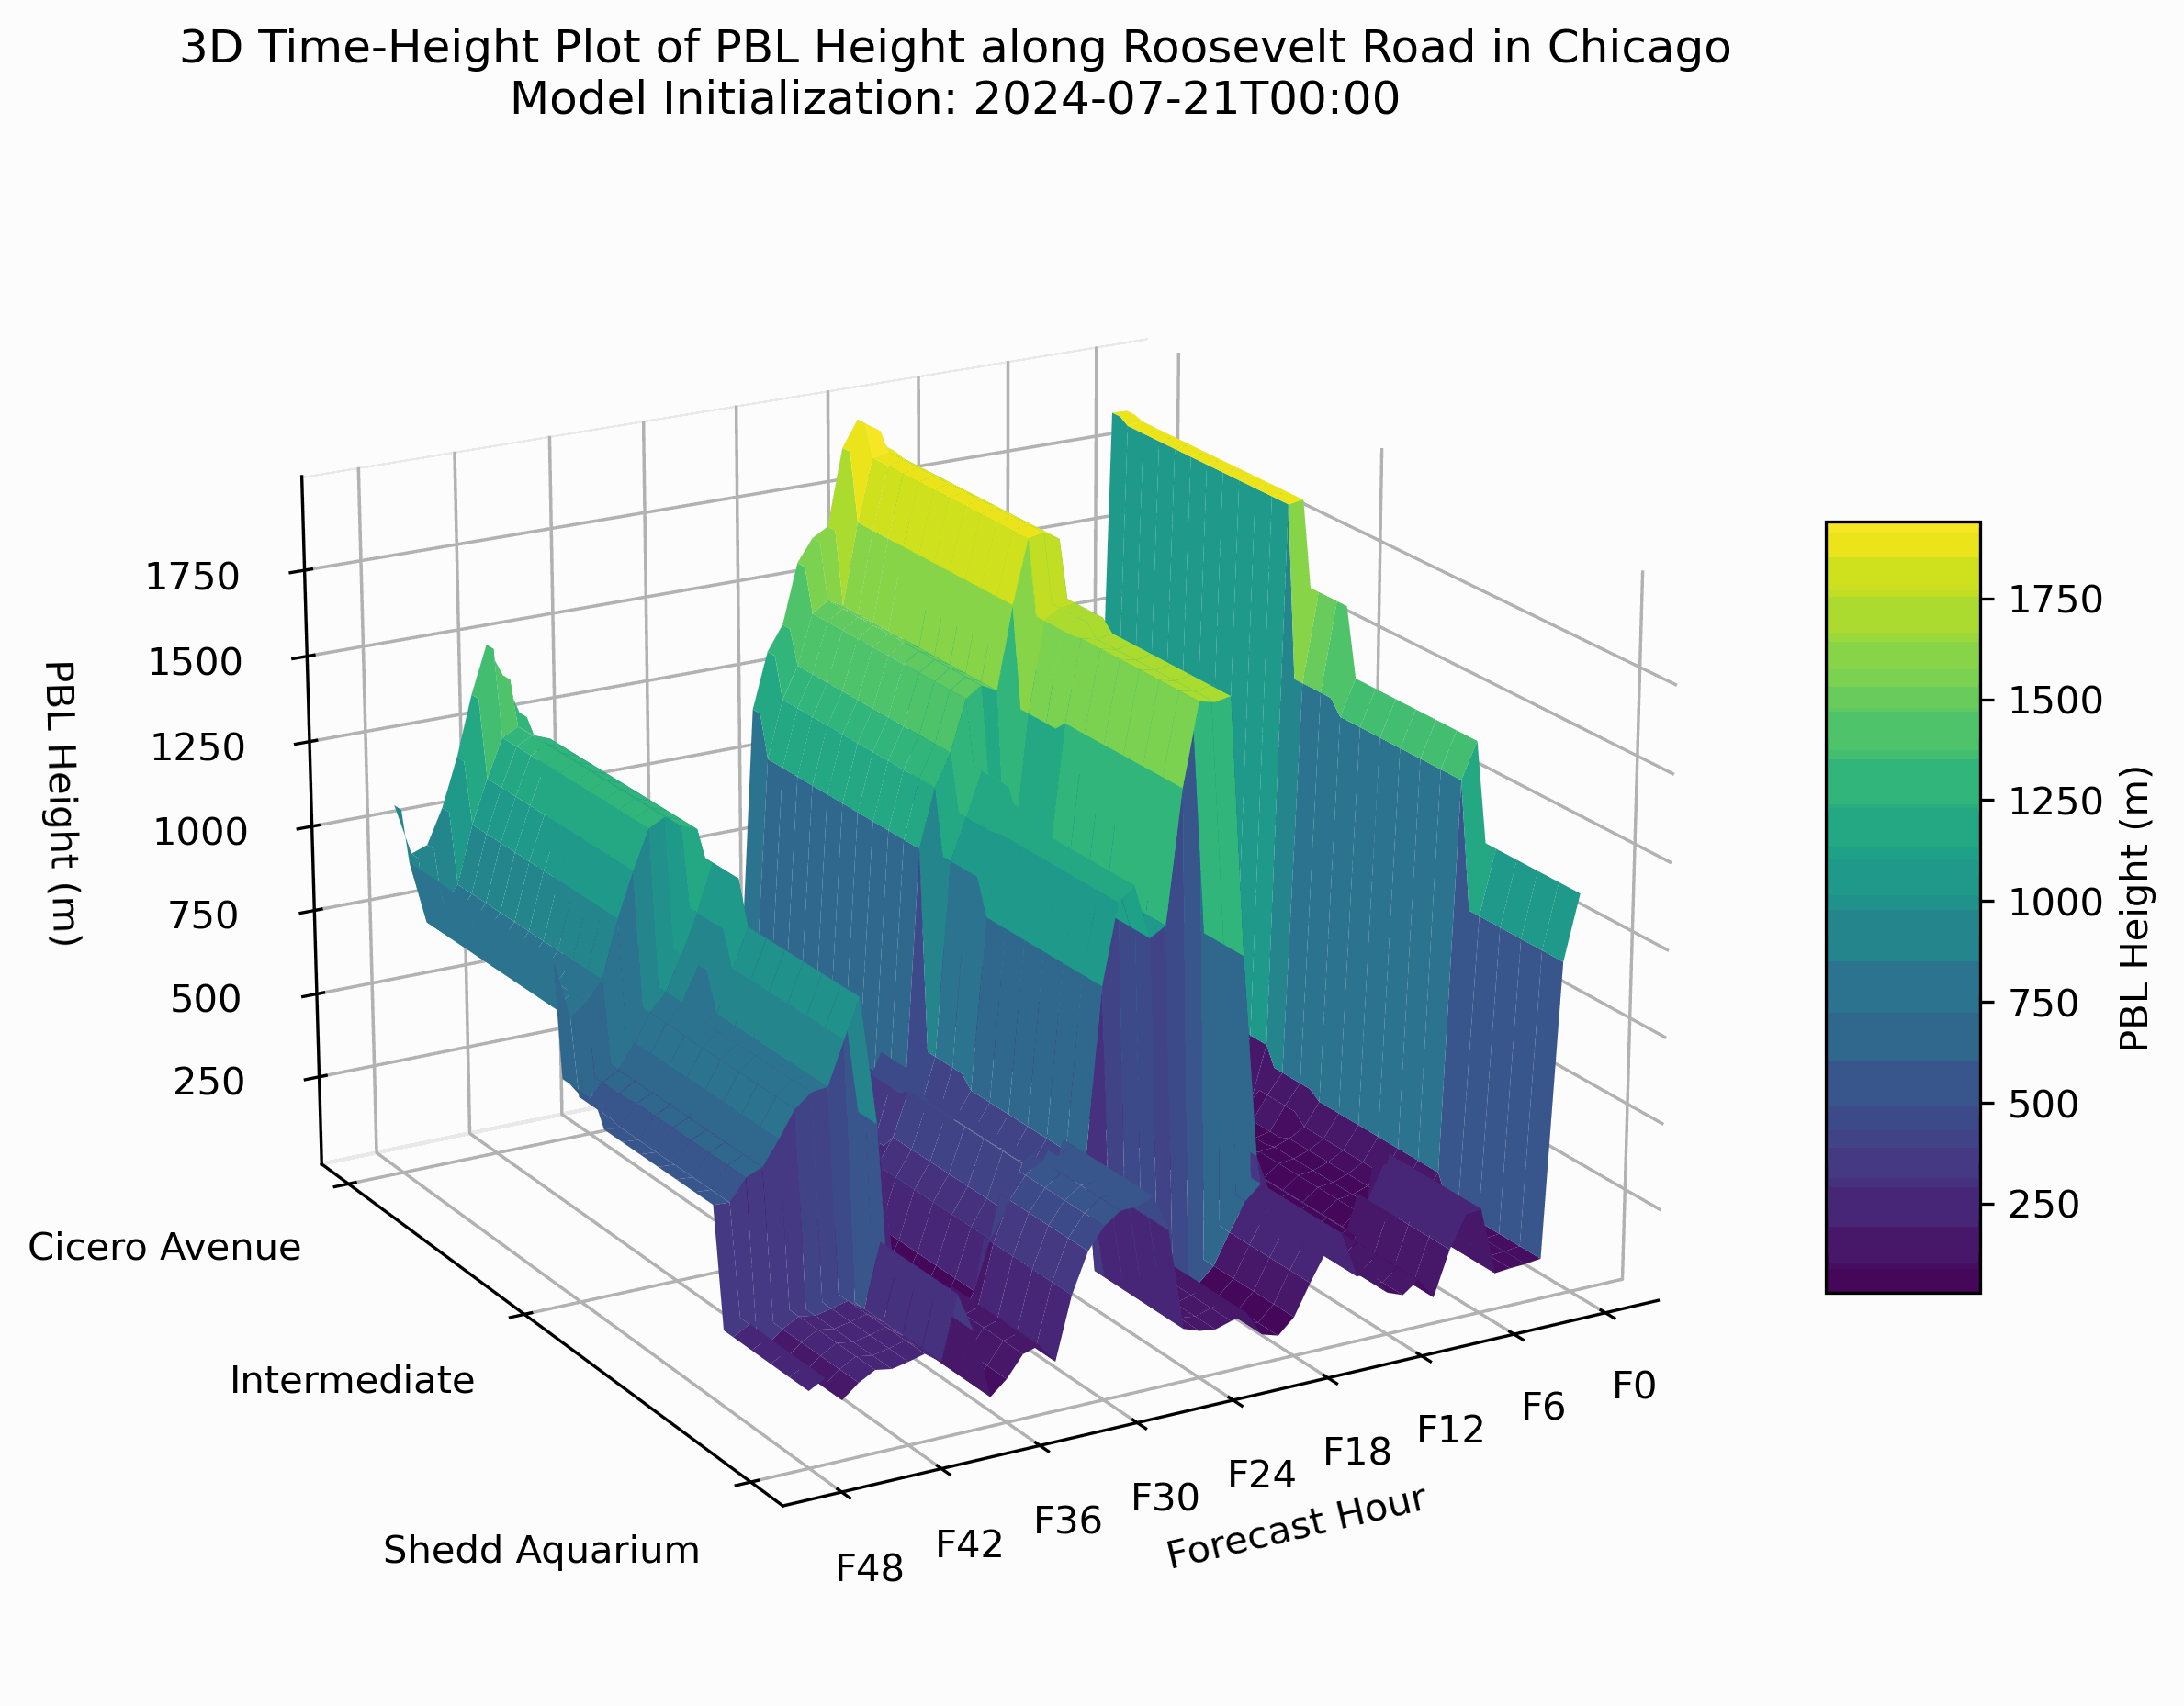

In [30]:
def main():
    date = input("Enter the date (e.g., 2024-06-24 18:00): ")
    model = "hrrr"
    max_fxx = int(input("Enter the maximum forecast hour (For 0, 6, 12, 18z, its 48, anything else it's 18): "))

    output_gif = "PBL_time_height_plot_3d.gif"
    create_animated_gif_time_height(date, model, max_fxx, output_gif)

    print(f"3D Time-Height Plot GIF saved as {output_gif}")

    if os.path.exists(output_gif):
        with open(output_gif, 'rb') as f:
            display(IPImage(data=f.read(), format='gif'))
    else:
        print("Output GIF file does not exist. Please check the script for errors.")

if __name__ == "__main__":
    main()

# Summary
Now we know how to make a 3D-plot of the boundary layer heights over a coordinate line. Feel free to adjust the viewing angle (Azimuth) and the Elevation (Elevation) in the code to view it from a different perspective. 